### Questions for Reflection:
- **Why are convolutional layers more efficient than fully connected layers for image data?**
Because they are designed to detect patters on the image by focusing on local features (like shape, texture, edges, etc) and reducing the number of parameters
- **What is the purpose of pooling layers in a CNN?**
Reduce the spatial size of the image (width and height) while keeping the most important information
- **Why do we apply ReLU after the convolutional layers?**
To introduce non-linearity, which allows the network to model more complex patterns. Also, it helps avoid the *Vanishing Gradient* problem, as it doesn't squash gradients like other activation functions (Tanh, sigmoid, ...)
- **What does overfitting look like in a CNN, and how can you reduce it?**
The train loss will be significatively smaller than the test loss or the validation loss, and we can reduce it by introducing dropout layers, that ignore a set of neurons during training. Overfitting (in CNNs) occurs when the model learns the training data too well, including noise, and performs poorly on unseen data. Other methods to reduce overfitting are Data Augmentation (randomly altering the training images), L2 regularization (weight decay) or Early stopping.
- **Why do we flatten the output of convolutional layers before feeding it into fully connected layers?**
To convert the 2D feature maps from the convolutional layer (high-level pictures, not raw pixels anymore) into a 1D vector that can be fed into the fully connected (dense) layers, which expect a flat input. The fully connected layers then interprete these high-level features and make final predictions.

# Problem Overview: Classifying CIFAR-10 Dataset Using CNNs
We’ll now work with the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 different classes (e.g., airplanes, cars, cats, dogs, etc.). Your task will be to build a CNN to classify these images.

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [5]:
image, label = train_dataset[0]
print(f'Image shape: {image.shape}, Label: {label}')

Image shape: torch.Size([3, 32, 32]), Label: 6


*Explanation of Changes:*

Denormalization: Since the images were normalized (with mean 0.5 and std 0.5), you need to "denormalize" them before visualizing. This is done by reversing the normalization: img = img * 0.5 + 0.5.

Handling RGB Images: CIFAR-10 images are 3-channel RGB images. Instead of using squeeze() and cmap="gray" (which is for grayscale images), you need to convert the image to the correct shape for plt.imshow(). This is done by transposing the tensor from (C, H, W) to (H, W, C) using img.permute(1, 2, 0).

Correct Tensor Shape: PyTorch tensors store images in the format (channels, height, width), while matplotlib expects (height, width, channels) for RGB images, which is why we use .permute(1, 2, 0) to rearrange the dimensions.

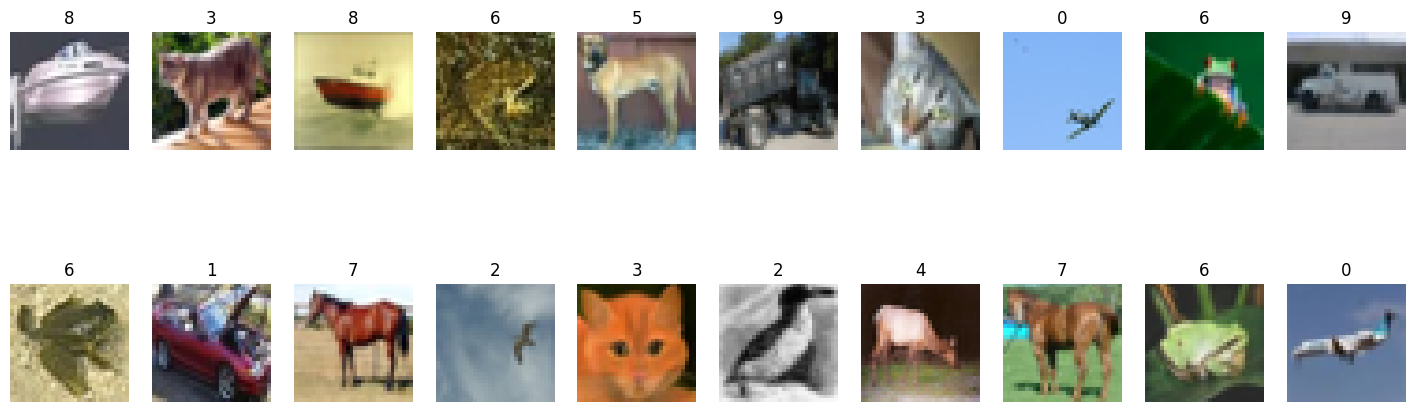

In [20]:
# Plot CIFAR-10 images
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    # Denormalize the image for proper visualization
    img = img * 0.5 + 0.5  # Reverse the normalization (0.5 mean, 0.5 std)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    
    # Convert from Tensor to NumPy and transpose the channels (C, H, W) -> (H, W, C)
    plt.imshow(img.permute(1, 2, 0))  # For RGB images, no need to use cmap="gray"
    
plt.show()

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # First conv layer (32 filters)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second conv layer (64 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window)

        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 feature maps of size 8x8
        self.fc2 = nn.Linear(512, 10)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten the output from the conv layers
        x = x.view(-1, 64 * 8 * 8)

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [9]:
#in_channels = 3
#out_classes = 10
model = CNN()

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()
        #print(running_loss)
    # Print the average loss after each epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 1.3094
Epoch 2/10, Loss: 0.9176
Epoch 3/10, Loss: 0.7233
Epoch 4/10, Loss: 0.5625
Epoch 5/10, Loss: 0.4064
Epoch 6/10, Loss: 0.2666
Epoch 7/10, Loss: 0.1569
Epoch 8/10, Loss: 0.1050
Epoch 9/10, Loss: 0.0766
Epoch 10/10, Loss: 0.0691


In [12]:
correct = 0
total = 0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')

Accuracy on the test set: 97.58%


# Problem Overview: Classifying Fashion-MNIST Dataset Using CNNs
We’ll now work with the Fashion-MNIST Dataset, very similar to the original MNIST dataset but contains images of clothing items instead of digits. It consists of 28x28 grayscale images of 10 different classes of fashion items (e.g., t-shirts, shoes, bags, etc.).

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 12370489.02it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 128773.12it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 2588205.92it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 22632.94it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

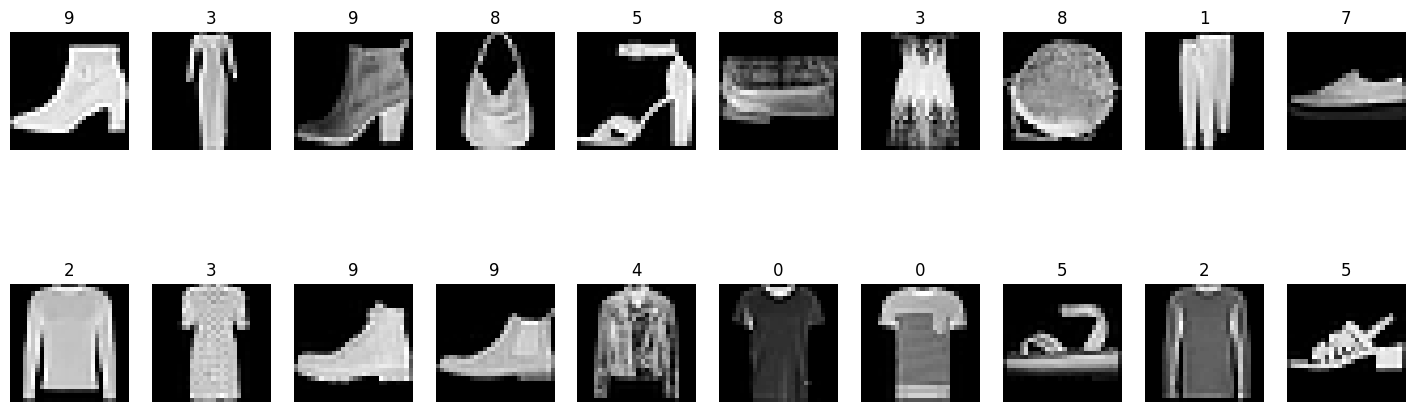

In [17]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [15]:
image, label = train_dataset[0]
print(f'Image shape: {image.shape}, Label: {label}')

Image shape: torch.Size([1, 28, 28]), Label: 9


In [20]:
class FashionCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FashionCNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1)  # First conv layer (32 filters), 32 channels feature map 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second conv layer (64 filters)  64 channels feature map 14x14
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer (2x2 window) #halves the feature map, first 28x28 to 14x14, then 14x14 to 7x7

        # Define fully connected layers
        self.linear1 = nn.Linear(64 * 7 * 7, 512)  # 64 feature maps of size 7x7
        self.linear2 = nn.Linear(512, output_size)  # 10 classes

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        # Flatten the output from the conv layers
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)

        return x

In [21]:
input_channels = image.shape[0]
output_classes = 10
model = FashionCNN(input_size=input_channels, output_size=output_classes)

In [26]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [30]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()

        pred = model(images)
        loss_fn = loss(pred, labels)

        loss_fn.backward()
        optimizer.step()

        running_loss += loss_fn.item()
        #print(running_loss)
    # Print the average loss after each epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/10, Loss: 0.3672
Epoch 2/10, Loss: 0.2576
Epoch 3/10, Loss: 0.2092
Epoch 4/10, Loss: 0.1763
Epoch 5/10, Loss: 0.1470
Epoch 6/10, Loss: 0.1188
Epoch 7/10, Loss: 0.0953
Epoch 8/10, Loss: 0.0755
Epoch 9/10, Loss: 0.0568
Epoch 10/10, Loss: 0.0453
